In [1]:
from exp.utils import *
from exp.models import *
from exp.losses import *
from fastai.vision.all import *

In [2]:
lr = 1e-2
bs = 32
epochs = 50
image_size = 224
device = get_device()

Using the GPU!


In [3]:
p_data = get_data_path()
p_train_valid = p_data/"train_valid_images"
p_train_images = p_train_valid/"train_images"
p_valid_images = p_train_valid/"valid_images"
p_test_images  = p_data/"test_images"
p_dev_images = p_data/"dev_images"

In [4]:
# Load data
label = "Cardiomegaly"
train_df, valid_df, test_df = get_dataframes(include_labels=get_labels(), 
                                             small=False)
#print(train_df.shape, valid_df.shape, test_df.shape)
train_df = get_binary_df(label, train_df)
valid_df = get_binary_df(label, valid_df)
test_df  = get_binary_df(label, test_df)

complete_df = pd.concat([train_df, valid_df, test_df])
complete_df = complete_df.drop(columns=["Follow-up #", "Patient ID", "Patient Age", "Patient Gender", 
                   "View Position", "OriginalImage[Width", "Height]", 
                   "OriginalImagePixelSpacing[x", "y]", "No Finding"])

In [5]:
def label_func(fname):
    lbl = complete_df[complete_df["Image Index"] == fname.name]["Cardiomegaly"].values[0]
    return "C" if lbl > 0 else "No C"

def splitter_func(fn):
    return fn.parent.stem == "valid_images" 

In [6]:
train_label = train_df[[label]].values
neg_weights, pos_weights = compute_class_freqs(train_label)
neg_weights, pos_weights = torch.Tensor(neg_weights), torch.Tensor(pos_weights)
weights = torch.Tensor([neg_weights, pos_weights]).to(device)
print(neg_weights, pos_weights)

tensor([0.0203]) tensor([0.9797])


In [7]:
item_tfms = [Resize(image_size, method="squish", pad_mode="zeros")
#             Brightness(),
#             Contrast(),
#             Warp()
#             RandomErasing(p=.5, max_count=6)
            ]

batch_tfms = [Brightness(), 
              Contrast(),
#              Warp(),
              RandomErasing(p=.5, max_count=6)
             ]          

In [8]:
dblock = DataBlock(blocks    = (ImageBlock, CategoryBlock),
                   get_items = get_image_files,
                   get_y     = label_func,
                   splitter  = RandomSplitter(),
                   item_tfms = item_tfms,
                   batch_tfms = batch_tfms)#)

dsets = dblock.datasets(p_dev_images)

In [9]:
dls = dblock.dataloaders(p_dev_images, bs=bs)

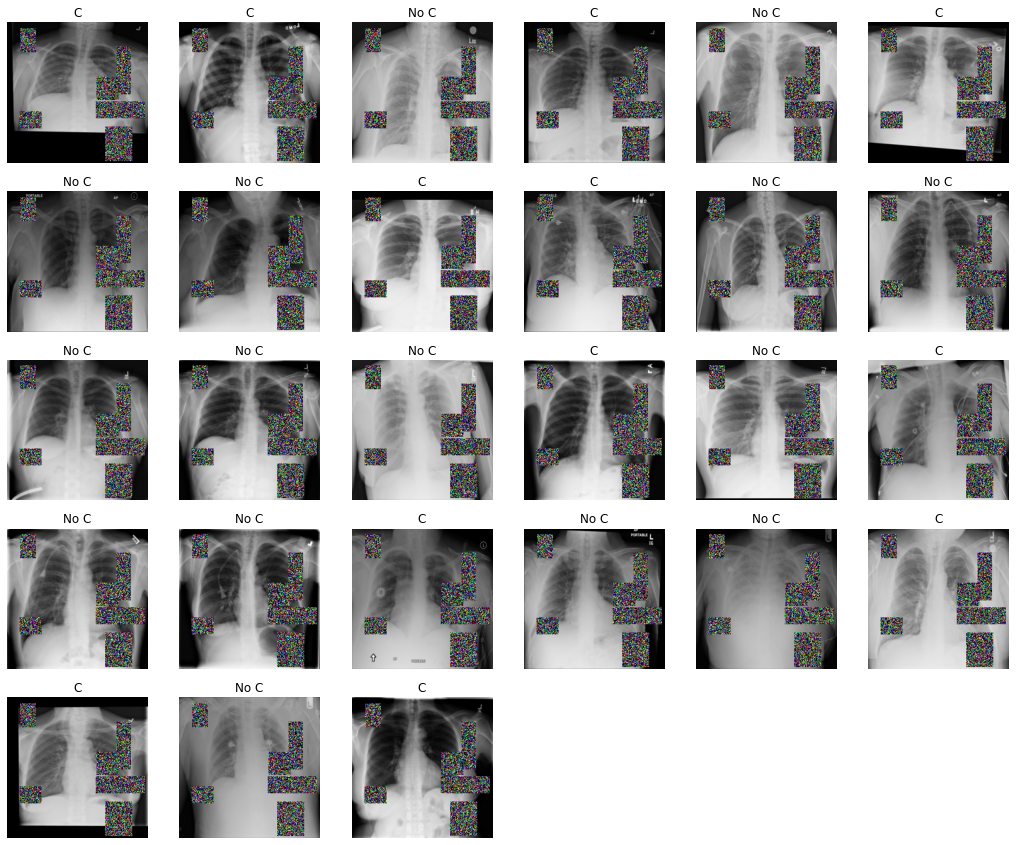

In [10]:
dls.train.show_batch(max_n=27)

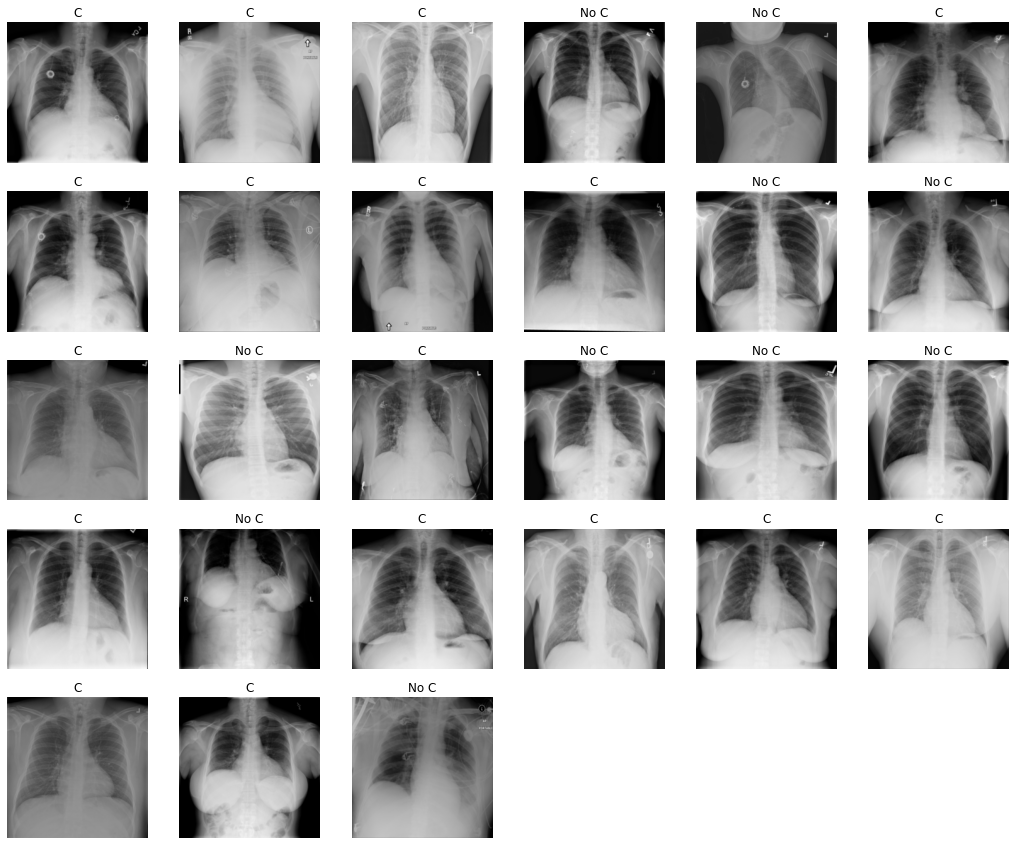

In [11]:
dls.valid.show_batch(max_n=27)

In [ ]:
#dblock = DataBlock(blocks    = (ImageBlock, CategoryBlock),
#                   get_items = get_image_files,
##                   get_y     = label_func,
#                   splitter  = FuncSplitter(splitter_func),
#                   item_tfms = Resize(224))#
#
#dsets = dblock.datasets(p_train_valid)

In [ ]:
#dls = dblock.dataloaders(p_train_valid, bs=bs)
#dls.show_batch(max_n=45)

In [12]:
learn = cnn_learner(dls, resnet18, lr=1e-4, loss_func=CrossEntropyLossFlat(), 
                    metrics=[accuracy, Precision(), Recall(), RocAucBinary()])

SuggestedLRs(lr_min=0.0005248074419796466, lr_steep=7.585775847473997e-07)

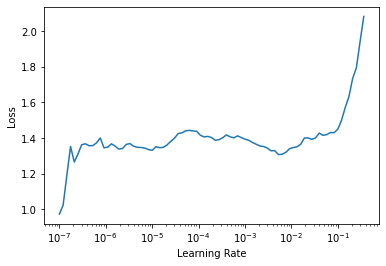

In [13]:
learn.lr_find()

In [ ]:
#interp = ClassificationInterpretation.from_learner(learn)
#interp.plot_confusion_matrix()

In [ ]:
#interp.plot_top_losses(9)

In [ ]:
#learn.summary()
#learn.lr_find()

In [14]:
learn.fine_tune(epochs, freeze_epochs=5, base_lr=3e-4)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,roc_auc_score,time
0,1.353805,0.930325,0.515385,0.546392,0.392593,0.546844,00:04
1,1.279196,0.854207,0.550000,0.569231,0.548148,0.573156,00:04
2,1.248067,0.863703,0.557692,0.596154,0.459259,0.603911,00:04
3,1.170540,0.828285,0.561538,0.562874,0.696296,0.614281,00:04
4,1.105361,0.852416,0.565385,0.567073,0.688889,0.601956,00:04


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,roc_auc_score,time
0,0.959948,0.835099,0.561538,0.568627,0.644444,0.625067,00:04
1,0.945686,0.831428,0.576923,0.591241,0.600000,0.624178,00:04
2,0.958777,0.817132,0.584615,0.585987,0.681481,0.628148,00:04
3,0.960405,0.849790,0.592308,0.617886,0.562963,0.634607,00:04
4,0.935725,0.827605,0.550000,0.552326,0.703704,0.640948,00:04
5,0.908546,0.804270,0.576923,0.570621,0.748148,0.641185,00:04
6,0.905908,0.788162,0.600000,0.613139,0.622222,0.653511,00:04
7,0.889564,0.778349,0.592308,0.609023,0.600000,0.660089,00:04
8,0.876348,0.797054,0.603846,0.591954,0.762963,0.665185,00:04
9,0.849322,0.743841,0.588462,0.593333,0.659259,0.674607,00:04


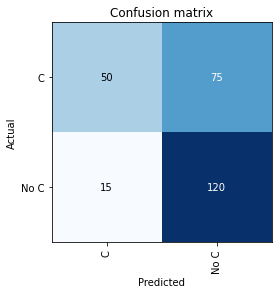

In [15]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

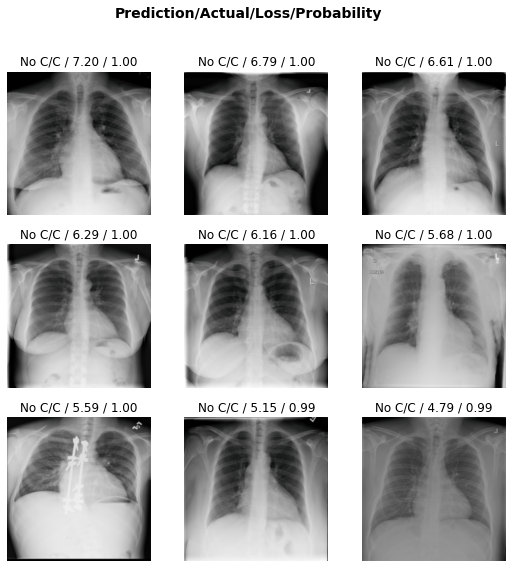

In [16]:
interp.plot_top_losses(9)

In [139]:
learn.save("resnet18_balanced_pretrain_v2", with_opt=True)

Path('models/resnet18_balanced_pretrain_v1.pth')

In [37]:
test_dblock = DataBlock(blocks    = (ImageBlock, CategoryBlock),
                        get_items = get_image_files,
                        get_y     = label_func,
                        splitter  = FuncSplitter(lambda x: False),
                        item_tfms = item_tfms)

In [ ]:
test_dls = test_dblock.dataloaders(p_test_images, bs=bs)

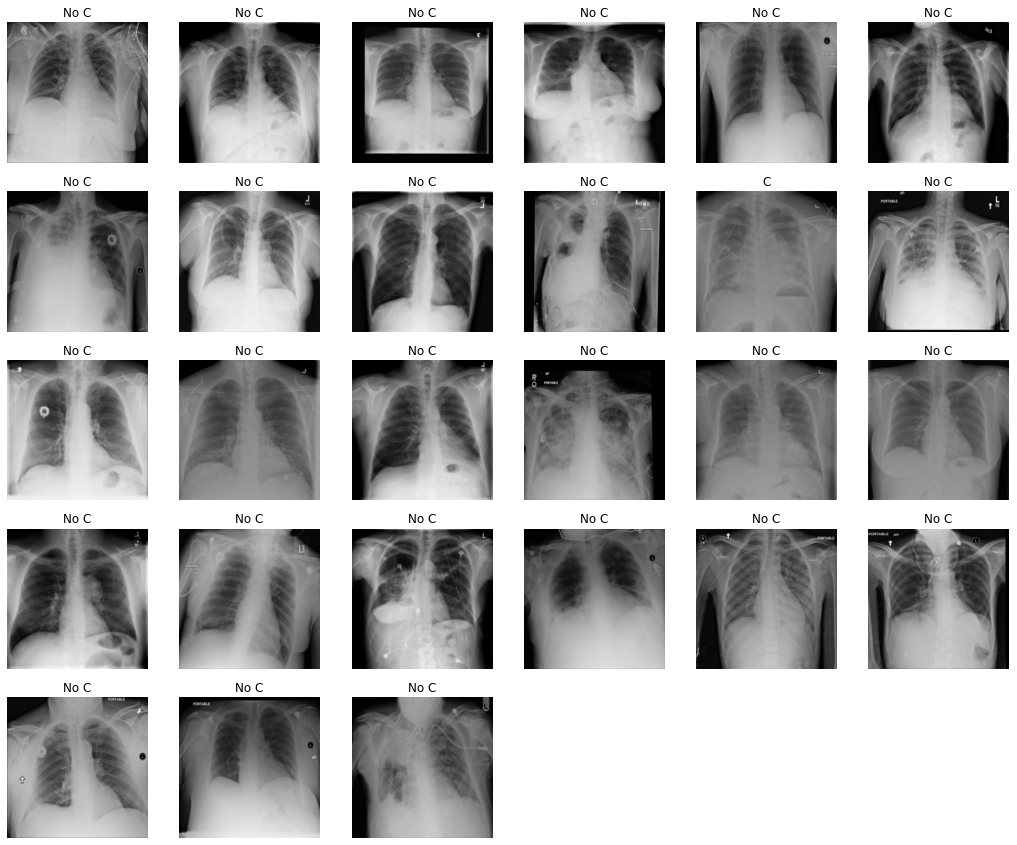

In [39]:
test_dls.train.show_batch(max_n=27)

In [44]:
test_dls.valid = test_dls.train

In [45]:
test_learn = cnn_learner(test_dls, resnet18, lr=1e-4, loss_func=CrossEntropyLossFlat(), 
                    metrics=[accuracy, Precision(), Recall(), RocAucBinary()])

In [46]:
test_learn.model = learn.model

In [ ]:
interp = ClassificationInterpretation.from_learner(test_learn)

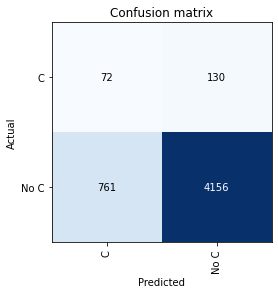

In [23]:
interp.plot_confusion_matrix()

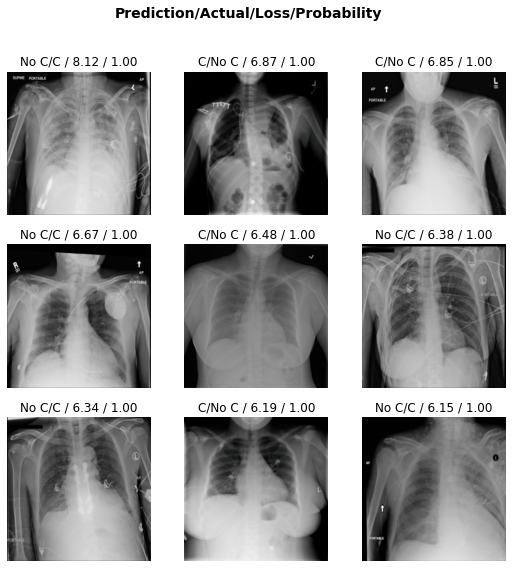

In [24]:
interp.plot_top_losses(9)

In [25]:
interp.print_classification_report()

              precision    recall  f1-score   support

           C       0.09      0.36      0.14       202
        No C       0.97      0.85      0.90      4917

    accuracy                           0.83      5119
   macro avg       0.53      0.60      0.52      5119
weighted avg       0.93      0.83      0.87      5119



In [29]:
len(test_dls.train)

639

In [ ]:
learn.summary()

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()

In [ ]:
learn.fine_tune(epochs, 
                base_lr=0.002, 
                freeze_epochs=0, 
                lr_mult=100, 
                pct_start=0.3, 
                div=5.0, 
                div_final=100000.0, wd=None, moms=None, cbs=None, reset_opt=False)


In [ ]:
#learn.lr_find()

In [ ]:
learn.save("untrained_resnet18", with_opt=True)

In [ ]:
learn.fit_one_cycle(epochs, lr_max=lr)

In [ ]:
learn.fine_tune(3)

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.plot_confusion_matrix()

In [ ]:
interp.most_confused()

In [ ]:
interp.plot_top_losses(9)